In [1]:
import torch
print(torch.__version__)

1.0.0


In [2]:
import torchvision
print(torchvision.__version__)

0.2.1


In [3]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    devID, torch.cuda.get_device_name(devID)
else:
    print("Torch Cuda not avaialbe")

Torch Cuda not avaialbe


In [4]:
PATH ='data/'
!ls data

models	tmdb_5000_credits.csv  tmdb_5000_movies.csv  tmp


In [5]:
import pandas as pd 
import numpy as np 
import json

#movies = pd.read_csv(PATH+'tmdb_5000_movies.csv')
#credits = pd.read_csv(PATH+'tmdb_5000_credits.csv')

In [6]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)  #needed to make json objects lists rahter than strings
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [7]:
movies = load_tmdb_movies(PATH+'tmdb_5000_movies.csv')
credits = load_tmdb_credits(PATH+'tmdb_5000_credits.csv')

In [8]:
movies.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
id,19995,285,206647,49026,49529
keywords,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.438,139.083,107.377,112.313,43.927
production_companies,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'name': 'Walt Disney Pictures', 'id': 2}]"


In [9]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [10]:
credits.columns = ['id','title2','cast','crew']
credits.head()

,id,title2,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [11]:
df = movies.merge(credits,how='inner',on='id')
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,title2,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [13]:
df.shape

(4803, 23)

In [14]:
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [15]:
def splitJsonToList(obj, column):
    fullDict = []
    for i in obj[column]:
    #    dictLine = json.loads(i)
        localDict = []
        for items in i:
            localDict.append(items['name'])
    #    print(localDict)
        fullDict.append(localDict)
    return fullDict

In [16]:
# this would run if we didn't load csv files with json.load 
# fullDict = []
# for i in movies['genres']:
#     dictLine = json.loads(i)
#     localDict = []
#     for items in dictLine:
#         localDict.append(items['name'])
#     print(localDict)
#     fullDict.append(localDict)

In [17]:
df['genres'][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [18]:
df['keywords'][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [19]:
df['production_companies'][0]

[{'name': 'Ingenious Film Partners', 'id': 289},
 {'name': 'Twentieth Century Fox Film Corporation', 'id': 306},
 {'name': 'Dune Entertainment', 'id': 444},
 {'name': 'Lightstorm Entertainment', 'id': 574}]

In [20]:
df['production_countries'][0]

[{'iso_3166_1': 'US', 'name': 'United States of America'},
 {'iso_3166_1': 'GB', 'name': 'United Kingdom'}]

In [21]:
df['spoken_languages'][0]

[{'iso_639_1': 'en', 'name': 'English'},
 {'iso_639_1': 'es', 'name': 'Español'}]

In [22]:
df['cast'][0]

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1},
 {'cast_id': 25,
  'character': 'Dr. Grace Augustine',
  'credit_id': '52fe48009251416c750aca39',
  'gender': 1,
  'id': 10205,
  'name': 'Sigourney Weaver',
  'order': 2},
 {'cast_id': 4,
  'character': 'Col. Quaritch',
  'credit_id': '52fe48009251416c750ac9cf',
  'gender': 2,
  'id': 32747,
  'name': 'Stephen Lang',
  'order': 3},
 {'cast_id': 5,
  'character': 'Trudy Chacon',
  'credit_id': '52fe48009251416c750ac9d3',
  'gender': 1,
  'id': 17647,
  'name': 'Michelle Rodriguez',
  'order': 4},
 {'cast_id': 8,
  'character': 'Selfridge',
  'credit_id': '52fe48009251416c750ac9e1',
  'gender': 2,
  'id': 1771,
  'name': 'Giovanni Ribisi',
  'order': 5},
 {'cast_id': 7,
  'c

In [23]:
df['crew'][0]

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'},
 {'credit_id': '54491cb70e0a267480001bd0',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Supervising Sound Editor',
  'name': 'Christopher Boyes'},
 {'credit_id': '539c4a4cc3a36810c9002101',
  'department': 'Production',
  'gender': 1,
  'id': 1262,
  'job': 'Casting',
  'name': 'Mali Finn'},
 {'credit_id': '5544ee3b925141499f0008fc',
  'department': 'Sound',
  'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'credit_id': '52fe48009251416c750ac9c3',
  'department': 'Directing',
  

In [24]:
df2 = df.copy()

In [25]:
features = ['genres', 'cast', 'crew', 'keywords','production_companies', 'production_countries', 'spoken_languages']
for column in features:
    df2[column] = splitJsonToList(df2, column)

In [26]:
#movies2['genres'] = splitJsonToList(movies2, 'genres')
#['id', 'budget', 'original_title', 'popularity', 'vote_average', 'vote_count']

In [27]:
df2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,title2,cast,crew
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B..."
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",...,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe..."
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]",...,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John..."
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",...,165.0,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan..."
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],...,132.0,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter..."


In [28]:
n_movies=int(df2.id.nunique())
n_movies

4803

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [30]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(df2, test_size=0.2)
# print(train.shape,test.shape)

In [31]:
# select only few relative columns
df_small = df[['id', 'budget', 'popularity', 'vote_average', 'vote_count']].copy()

In [32]:
df_small.head()

,id,budget,popularity,vote_average,vote_count
0,19995,237000000,150.437577,7.2,11800
1,285,300000000,139.082615,6.9,4500
2,206647,245000000,107.376788,6.3,4466
3,49026,250000000,112.312950,7.6,9106
4,49529,260000000,43.926995,6.1,2124


In [33]:
# check cardinality of some variables
df_small['vote_count'].value_counts()

0       62
1       53
2       46
4       43
3       41
6       38
8       37
10      34
11      32
9       32
7       31
5       28
15      26
19      26
12      26
13      25
16      24
22      23
34      23
31      22
24      22
18      22
17      21
25      20
26      20
23      19
27      19
66      19
29      19
47      18
        ..
382      1
2435     1
2439     1
402      1
2395     1
4500     1
4524     1
2491     1
2495     1
8662     1
474      1
2399     1
4432     1
2143     1
2251     1
8428     1
1221     1
2199     1
162      1
170      1
2247     1
2263     1
4412     1
2271     1
230      1
2295     1
266      1
2359     1
314      1
2039     1
Name: vote_count, Length: 1609, dtype: int64

In [34]:
# we don't have to dead with nan filling, since all values valid
df_small.isnull().values.any()

False

In [35]:
#df_small.T
df_small.head()

,id,budget,popularity,vote_average,vote_count
0,19995,237000000,150.437577,7.2,11800
1,285,300000000,139.082615,6.9,4500
2,206647,245000000,107.376788,6.3,4466
3,49026,250000000,112.312950,7.6,9106
4,49529,260000000,43.926995,6.1,2124


In [36]:
# check cardinality of some variables
df_small['budget'].value_counts()

0            1037
20000000      144
30000000      128
25000000      126
40000000      123
15000000      120
35000000      102
10000000      101
50000000      101
60000000       86
5000000        84
12000000       79
8000000        62
70000000       60
80000000       59
18000000       59
6000000        55
7000000        55
2000000        54
45000000       52
3000000        51
4000000        49
1000000        48
75000000       47
55000000       45
28000000       42
100000000      41
150000000      41
11000000       41
13000000       41
             ... 
41677699        1
123000000       1
1650000         1
3700000         1
10200000        1
1488423         1
20500000        1
12899867        1
180000          1
237000000       1
56000           1
325000          1
2280000         1
15300000        1
3100000         1
2540800         1
19500000        1
12516654        1
2627000         1
10284523        1
14200000        1
22000           1
97250400        1
78146652        1
3730500   

We need to instantiate an object of the TabularData class we created earlier. But before that, we need to label encode the categorical features. For this, we will be using sklearn.preprocessing.LabelEncoder. 

In [37]:
categorical_features = ["id", "vote_average", "vote_count", "budget"]
output_feature = "popularity"

In [38]:
df_small.head()

,id,budget,popularity,vote_average,vote_count
0,19995,237000000,150.437577,7.2,11800
1,285,300000000,139.082615,6.9,4500
2,206647,245000000,107.376788,6.3,4466
3,49026,250000000,112.312950,7.6,9106
4,49529,260000000,43.926995,6.1,2124


In [39]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 5 columns):
id              4803 non-null int64
budget          4803 non-null int64
popularity      4803 non-null float64
vote_average    4803 non-null float64
vote_count      4803 non-null int64
dtypes: float64(2), int64(3)
memory usage: 225.1 KB


In [40]:
import sklearn
print(sklearn.__version__)

0.20.2


In [41]:
import numpy as np
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X, X_test = train_test_split( df_small, test_size=0.33, random_state=42)


#df_small, df_small_test = cv.train_test_split(df_small, test_size=0.25)

In [42]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        X[cat_col] = label_encoders[cat_col].fit_transform(X[cat_col])

/home/norvilr/anaconda3/envs/torch10/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
df_small.shape, X.shape, X_test.shape

((4803, 5), (3218, 5), (1585, 5))

In [44]:
from torch.utils.data import Dataset, DataLoader


class TabularDataset(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

Let’s instantiate an object of the TabularDataset class. 

In [45]:
# Pytorch abstract class representing a Dataset.
#All other datasets should subclass it. All subclasses should override
#``__len__``, that provides the size of the dataset, and ``__getitem__``,

dataset = TabularDataset(data=X, cat_cols=categorical_features,
                             output_col=output_feature)

In [46]:
dataset.cat_cols,dataset.cat_X, dataset.cont_cols, dataset.cont_X, dataset.y, dataset.n

(['id', 'vote_average', 'vote_count', 'budget'],
 array([[1769,   22,   11,    0],
        [1279,   44,  137,  164],
        [ 328,   46,  987,  280],
        ...,
        [2186,   41,  209,  164],
        [ 676,   42,   80,  118],
        [2198,   49,  509,  264]]),
 [],
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 array([[ 1.65426 ],
        [ 9.525626],
        [57.69847 ],
        ...,
        [14.979375],
        [ 6.091951],
        [22.863516]], dtype=float32),
 3218)

In [47]:
len(dataset.cont_cols)

0

In [48]:
len(dataset.cat_cols)

4

In [49]:
len(dataset)

3218

In order to run the training loop, we need to create a torch.util.data.Dataloader object. It serves the following purpose –
 -   creates batches from the dataset
 -   shuffles the data
 -   loads the data in parallel

In [50]:
#??DataLoader
#    Data loader. Combines a dataset and a sampler, and provides
#    single- or multi-process iterators over the dataset.

In [51]:
batchsize = 64
dataloader = DataLoader(dataset, batchsize, shuffle=True, num_workers=1)

In [52]:
dataloader.batch_size

64

In [53]:
#iter(dataloader).next()

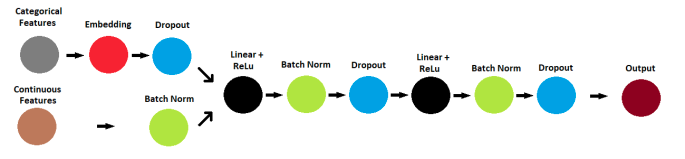

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_size, emb_dropout, lin_layer_dropouts):

    """
    Parameters
    ----------

    emb_dims: List of two element tuples
      This list will contain a two element tuple for each
      categorical feature. The first element of a tuple will
      denote the number of unique values of the categorical
      feature. The second element will denote the embedding
      dimension to be used for that feature.

    no_of_cont: Integer
      The number of continuous features in the data.

    lin_layer_sizes: List of integers.
      The size of each linear layer. The length will be equal
      to the total number
      of linear layers in the network.

    output_size: Integer
      The size of the final output.

    emb_dropout: Float
      The dropout to be used after the embedding layers.

    lin_layer_dropouts: List of floats
      The dropouts to be used after each linear layer.
    """

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                  output_size)
    nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)

    x = self.output_layer(x)

    return x

In [55]:
''' Example Neural Net for MovieLens dataset (Users, Movies)

lass EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5
'''

' Example Neural Net for MovieLens dataset (Users, Movies)\n\nlass EmbeddingNet(nn.Module):\n    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):\n        super().__init__()\n        (self.u, self.m) = [get_emb(*o) for o in [\n            (n_users, n_factors), (n_movies, n_factors)]]\n        self.lin1 = nn.Linear(n_factors*2, nh)\n        self.lin2 = nn.Linear(nh, 1)\n        self.drop1 = nn.Dropout(p1)\n        self.drop2 = nn.Dropout(p2)\n        \n    def forward(self, cats, conts):\n        users,movies = cats[:,0],cats[:,1]\n        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))\n        x = self.drop2(F.relu(self.lin1(x)))\n        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5\n'

Now that we have created the basic data structure to run the training loop, we need to instantiate a model object of the FeedForwadNN class created earlier. This class requires a list of tuples, where each tuple represents a pair of total and the embedding dimension of a categorical variable

In [56]:
cat_dims = [int(X[col].nunique()) for col in categorical_features]
cat_dims

[3218, 67, 1276, 355]

In [57]:
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
emb_dims

[(3218, 50), (67, 34), (1276, 50), (355, 50)]

 The hidden layer dimension is 50 and 100 for the first and second layers respectively. The embedding dropout used is 0.04. The hidden layer dropouts are 0.001 and 0.01. 

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cpu')

In [59]:

model = FeedForwardNN(emb_dims, no_of_cont=len(dataset.cont_cols), 
                      lin_layer_sizes=[50, 100],
                      output_size=1, emb_dropout=0.04,
                      lin_layer_dropouts=[0.001,0.01])
model = model.to(device)

In [60]:
model.train()

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(3218, 50)
    (1): Embedding(67, 34)
    (2): Embedding(1276, 50)
    (3): Embedding(355, 50)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=184, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
)

In [61]:
model.eval()

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(3218, 50)
    (1): Embedding(67, 34)
    (2): Embedding(1276, 50)
    (3): Embedding(355, 50)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=184, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
)

 Run the training loop

In [62]:
categorical_features

['id', 'vote_average', 'vote_count', 'budget']

In [74]:
no_of_epochs = 5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [71]:
# state = {'epoch': epoch + 1,
#          'state_dict': model.state_dict(),
#          'optim_dict' : optimizer.state_dict()}
model.train()

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(3218, 50)
    (1): Embedding(67, 34)
    (2): Embedding(1276, 50)
    (3): Embedding(355, 50)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=184, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
)

In [75]:
import os
import time
import copy

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(no_of_epochs):
    running_loss = 0.0
    #running_corrects = 0
    i=0
    print('Epoch {}/{}'.format(epoch, no_of_epochs - 1))
    #model.train()
    pid = os.getpid()
    for y, cont_x, cat_x in dataloader:
        i += 1
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)
        
        # Backward Pass and Optimization
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * cat_x.size(0)
        #running_corrects += torch.sum(preds == y.data)
        #print(running_loss)
        
        # print statistics
        if i % 1000:    # print every n mini-batches         
            print('{}\tTrain Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.4f}'.format(
                pid, epoch, i * len(cat_x), len(dataloader.dataset),
                100. * i / len(dataloader), loss.item()))
     
    epoch_loss = running_loss / len(dataset)
    epoch_acc = 0
    #epoch_loss = running_loss / dataset_sizes[phase]
    #epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    


Epoch 0/4
24120	Train Epoch: 0 [64/3218 (2%)] Loss: 274.2307
24120	Train Epoch: 0 [128/3218 (4%)] Loss: 671.0900
24120	Train Epoch: 0 [192/3218 (6%)] Loss: 798.0402
24120	Train Epoch: 0 [256/3218 (8%)] Loss: 658.3005
24120	Train Epoch: 0 [320/3218 (10%)] Loss: 381.6747
24120	Train Epoch: 0 [384/3218 (12%)] Loss: 510.1859
24120	Train Epoch: 0 [448/3218 (14%)] Loss: 612.4713
24120	Train Epoch: 0 [512/3218 (16%)] Loss: 327.0801
24120	Train Epoch: 0 [576/3218 (18%)] Loss: 4043.8059
24120	Train Epoch: 0 [640/3218 (20%)] Loss: 468.1407
24120	Train Epoch: 0 [704/3218 (22%)] Loss: 668.3242
24120	Train Epoch: 0 [768/3218 (24%)] Loss: 350.1294
24120	Train Epoch: 0 [832/3218 (25%)] Loss: 795.8213
24120	Train Epoch: 0 [896/3218 (27%)] Loss: 613.3520
24120	Train Epoch: 0 [960/3218 (29%)] Loss: 578.4757
24120	Train Epoch: 0 [1024/3218 (31%)] Loss: 554.8575
24120	Train Epoch: 0 [1088/3218 (33%)] Loss: 716.4010
24120	Train Epoch: 0 [1152/3218 (35%)] Loss: 12100.5869
24120	Train Epoch: 0 [1216/3218 (37

24120	Train Epoch: 3 [64/3218 (2%)] Loss: 443.4229
24120	Train Epoch: 3 [128/3218 (4%)] Loss: 509.4884
24120	Train Epoch: 3 [192/3218 (6%)] Loss: 994.2139
24120	Train Epoch: 3 [256/3218 (8%)] Loss: 618.1602
24120	Train Epoch: 3 [320/3218 (10%)] Loss: 541.8674
24120	Train Epoch: 3 [384/3218 (12%)] Loss: 544.6661
24120	Train Epoch: 3 [448/3218 (14%)] Loss: 527.1361
24120	Train Epoch: 3 [512/3218 (16%)] Loss: 874.6752
24120	Train Epoch: 3 [576/3218 (18%)] Loss: 756.4514
24120	Train Epoch: 3 [640/3218 (20%)] Loss: 238.3015
24120	Train Epoch: 3 [704/3218 (22%)] Loss: 3935.7507
24120	Train Epoch: 3 [768/3218 (24%)] Loss: 587.0323
24120	Train Epoch: 3 [832/3218 (25%)] Loss: 380.6061
24120	Train Epoch: 3 [896/3218 (27%)] Loss: 284.0929
24120	Train Epoch: 3 [960/3218 (29%)] Loss: 294.6056
24120	Train Epoch: 3 [1024/3218 (31%)] Loss: 604.1089
24120	Train Epoch: 3 [1088/3218 (33%)] Loss: 274.6200
24120	Train Epoch: 3 [1152/3218 (35%)] Loss: 429.3647
24120	Train Epoch: 3 [1216/3218 (37%)] Loss: 67